Download the appropriate packages: dplyr, ggplot2, and tidymodels

In [37]:
#Load packages
library(dplyr)
library(ggplot2)
library(tidymodels)

Data was derived from the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Heart+Disease) consisting of 4 databases from Cleveland, Hungary, Switzerland, and 
the VA Long Beach. The processed Cleveland database was used for this analysis.

In [38]:
#Load processed Cleveland heart disease dataset from database via URL
#Create a data directory to store the heart disease data
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
download.file(url, destfile = "data/heartdiseasecleveland.csv")
heartdisease_cleveland <- read.csv("data/heartdiseasecleveland.csv", header = FALSE)
heartdisease_cleveland <- as_tibble(heartdisease_cleveland)
head(heartdisease_cleveland)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


The database contains 76 attributes, but the processed database contains 14 attributes including Age, Sex, Trestbps, Chol, Fbs, Restecg, Thalach, Exang, Oldpeak, Slope, Ca, Thal, Num.
We will be using using Age and Sex and predictors to classify heart disease status denoted by Num. Further information regarding the 14 attributes can be found on the repository.

In [39]:
#Replace column names
names(heartdisease_cleveland) <- c("Age", "Sex", "Cp", "Trestbps", "Chol", "Fbs", "Restecg", "Thalach", "Exang", "Oldpeak", "Slope", "Ca", "Thal", "Num")
head(heartdisease_cleveland)

Age,Sex,Cp,Trestbps,Chol,Fbs,Restecg,Thalach,Exang,Oldpeak,Slope,Ca,Thal,Num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


In [40]:
#Select columns: Age, Chol, Num
heartdisease_cleveland <- heartdisease_cleveland %>%
  select(Age, Chol, Num)
head(heartdisease_cleveland)

Age,Chol,Num
<dbl>,<dbl>,<int>
63,233,0
67,286,2
67,229,1
37,250,0
41,204,0
56,236,0


Individuals will be defined as positive for heart disease if they have a Num score > 0 to denote >50% diameter narrowing of blood vessels and will be defined as negative if they have a 
Num score = 0 to denote <50% diameter narrowing.

In [41]:
#Convert outcome (Num) to categorical
heartdisease_cleveland$Num[which(heartdisease_cleveland$Num > 0)] <- c("Positive") #>50% diameter narrowing
heartdisease_cleveland$Num[which(heartdisease_cleveland$Num == 0)] <- c("Negative") #<50% diameter narrowing
heartdisease_cleveland$Num <- as.factor(heartdisease_cleveland$Num)
class(heartdisease_cleveland$Num) 

[1] "factor"

Data was randomly split into a training set and testing set. The training set contains 75% of all observations and the testing set contains 25% of all observations.

In [42]:
#Create training dataset and test dataset
split <- initial_split(heartdisease_cleveland, prop = 0.75, strata = Num)
train <- training(split)
test <- testing(split)
glimpse(train)
glimpse(test)

Rows: 228
Columns: 3
$ Age  <dbl> 63, 67, 37, 41, 57, 63, 53, 57, 56, 44, 52, 57, 48, 54, 48, 49, …
$ Chol <dbl> 233, 229, 250, 204, 354, 254, 203, 192, 256, 263, 199, 168, 229,…
$ Num  <fct> Negative, Positive, Negative, Negative, Negative, Positive, Posi…
Rows: 75
Columns: 3
$ Age  <dbl> 67, 56, 62, 56, 66, 69, 59, 42, 50, 44, 60, 51, 60, 65, 51, 45, …
$ Chol <dbl> 286, 236, 268, 294, 226, 239, 234, 226, 243, 290, 253, 305, 282,…
$ Num  <fct> Positive, Negative, Positive, Negative, Negative, Negative, Nega…


Predictors Age and Chol was standardized for future determination of K-nearest neighbors.

In [43]:
#Standardize training data
train_recipe <- recipe(Num ~ Age + Chol, data = train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>%
    prep()
train_recipe

train <- bake(train, train_recipe)
train

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Training data contained 228 data points and no missing data.

Operations:

Scaling for Age, Chol [trained]
Centering for Age, Chol [trained]

ERROR: Error in UseMethod("bake"): no applicable method for 'bake' applied to an object of class "c('tbl_df', 'tbl', 'data.frame')"


Predictor parameters mean, minimum, and maximum were summarized into a table. Individuals positive for heart disease (Num > 0) and negative for heart disease (Num = 0) were separated into individual observations with the total number of patients recorded under Heart_Disease_Num and shown as a percentage value under Percent_of_Total.

In [44]:
#Summarize training data into table 
train_summary <- train %>%
    mutate(Add = 1) %>%
    mutate(Total = sum(Add)) %>%
    group_by(Num) %>%
    summarize(Mean_Age = mean(Age, na.rm = TRUE),
              Min_Age = min(Age, na.rm = TRUE),
              Max_Age = max(Age, na.rm = TRUE),
              Mean_Chol = mean(Chol, na.rm = TRUE),
              Min_Chol = min(Chol, na.rm = TRUE),
              Max_Chol = max(Chol, na.rm = TRUE),
              Heart_Disease_Num = sum(Add),
              Percent_of_Total = (Heart_Disease_Num/Total[1:1])*100
             )
train_summary

`summarise()` ungrouping output (override with `.groups` argument)



Num,Mean_Age,Min_Age,Max_Age,Mean_Chol,Min_Chol,Max_Chol,Heart_Disease_Num,Percent_of_Total
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Negative,52.41463,34,74,242.1138,141,417,123,53.94737
Positive,56.63810,35,70,247.4476,149,407,105,46.05263


Scatterplot showing standardized predictors age (x-axis) and cholesterol level (y-axis) categorized by heart disease status (positive/negative). 

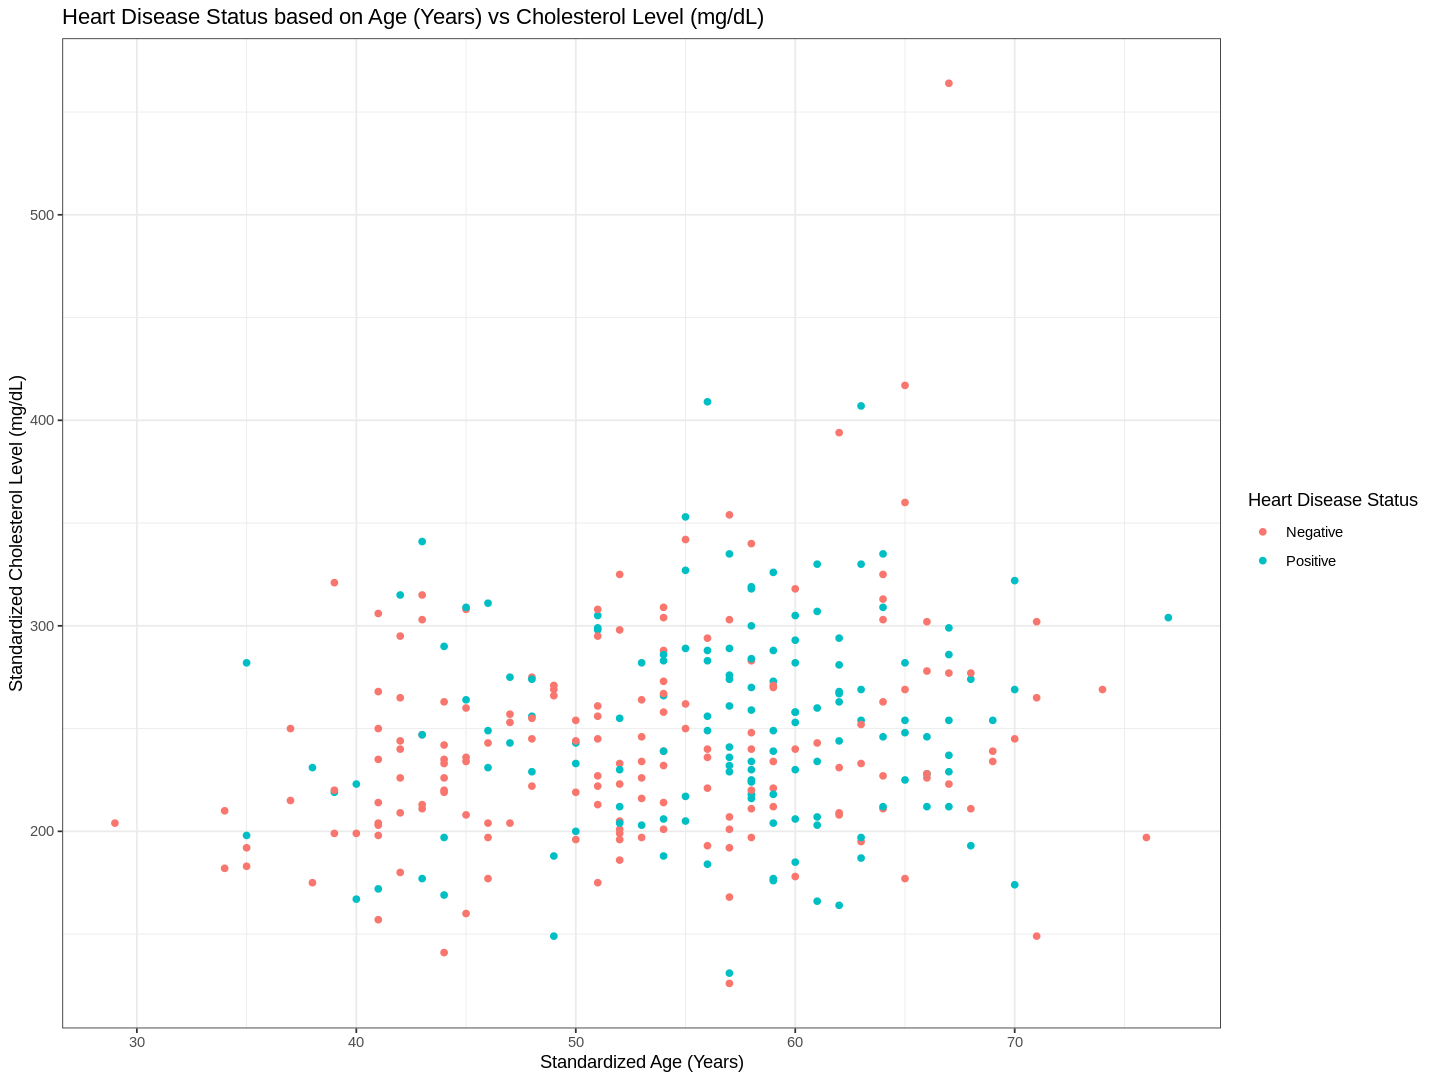

In [45]:
#Create scatterplot showing age vs chol colored by heart disease status
options(repr.plot.width = 12, repr.plot.height = 9) 

age_chol_plot <- ggplot(heartdisease_cleveland, aes(x = Age, y = Chol, color = Num)) + 
    geom_point() + 
    labs(x = "Standardized Age (Years)", y = "Standardized Cholesterol Level (mg/dL)", color = "Heart Disease Status") +
    ggtitle("Heart Disease Status based on Age (Years) vs Cholesterol Level (mg/dL)") +
    theme_bw()
age_chol_plot